# Parse World Coffee Research Coffee Bean Catalog

A PDF downloaded from https://varieties.worldcoffeeresearch.org/ contains information about different varieties of coffee beans.

To parse the PDF, we use pypdf, specifically the `extract_text()` function along with regular expressions. See more:\
https://pypdf.readthedocs.io/en/latest/user/extract-text.html

## Parsing

In [ ]:
from pypdf import PdfReader
import json
import csv
import re

def extract_info(text):
    # define valid uppercase key patterns (first set for arabica, second set for robusta)
    valid_keys = (
        "SPECIES|NAME|DESCRIPTION|STATURE|LEAF TIP COLOR|BEAN SIZE|YIELD POTENTIAL|QUALITY POTENTIAL AT HIGH ALTITUDE|"
        "OPTIMAL ALTITUDE|COFFEE LEAF RUST|NEMATODE|COFFEE BERRY DISEASE|YEAR OF FIRST PRODUCTION|"
        "NUTRITION REQUIREMENT|RIPENING OF FRUIT|CHERRY TO GREEN BEAN OUTTURN|PLANTING DENSITY|"
        "ADDITIONAL AGRONOMIC INFORMATION|GENETIC DESCRIPTION|LINEAGE|BREEDER|"
        
        "SPECIES|NAME|DESCRIPTION|YIELD POTENTIAL|COUNTRY OF RELEASE|CONTENTS OF MUCILAGE IN THE CHERRY|BEAN SIZE|COFFEE LEAF RUST|"
        "COFFEE BERRY DISEASE|NEMATODE|COFFEE BERRY BORER|SHOOT HOLE BORER \\(XYLOSANDUS COMPACTUS\\)|STATURE|"
        "YEAR OF FIRST PRODUCTION|NUTRITION REQUIREMENT|RIPENING OF FRUIT|CHERRY TO GREEN BEAN OUTTURN|"
        "PLANTING DENSITY|LEAF TIP COLOR|ADDITIONAL AGRONOMIC INFORMATION|TYPE|GENETIC DESCRIPTION|LINEAGE|BREEDER"
    )

    # finds uppercase keys and captures text until the next valid key or end of text
    pattern = rf'({valid_keys})\s+(.+?)(?=\s+\b(?:{valid_keys})\b|$)'

    matches = re.finditer(pattern, text, re.DOTALL)

    return {match.group(1).strip().lower(): (match.group(2) or "").strip() for match in matches}

def transform_text(text):
    # append some keys where needed
    words = text.split(" ", 2)
    if len(words) > 2:
        words.insert(0, "SPECIES")
        words.insert(2, "NAME")
        words.insert(4, "DESCRIPTION")
    words[1] = words[1].title()
    return " ".join(words)

def clean_text(text):
    # initial cleaning
    text = text.replace("\xa0", "None").replace("\nAgronomics\n", "\n").replace("\nBackground\n", "\n")

    # remove limit descriptors
    pattern_part = r"(VERY LOW|LOW|MEDIUM|GOOD|VERY GOOD|HIGH|VERY HIGH|EXCEPTIONAL|SUSCEPTIBLE|RESISTANT)"
    pattern = rf"\n{pattern_part} {pattern_part}\n"

    return re.sub(pattern, "\n", text).replace("\n", " ").strip()

def process_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    processed = []

    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            cleaned_text = clean_text(page_text)
            transformed_text = transform_text(cleaned_text)
            extracted_data = extract_info(transformed_text)
            processed.append(extracted_data)
    
    return processed

pdf_path = "WCRVarieties.pdf"
processed = process_pdf(pdf_path)

# save as json
json_path = "./intermediates/processed_coffee_data_v1.json"
with open(json_path, "w", encoding="utf-8") as json_file:
    json.dump(processed, json_file, indent=4, ensure_ascii=False)

In [168]:
import json
import csv

# save as csv

json_path = "./intermediates/processed_coffee_data_v2.json"
csv_path = "./intermediates/processed_coffee_data_v2.csv"

with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

if isinstance(data, dict) and isinstance(data.get("root"), list):
    data = data["root"]

all_fieldnames = set()
for entry in data:
    if isinstance(entry, dict):
        all_fieldnames.update(entry.keys())

fieldnames = sorted(all_fieldnames)

with open(csv_path, "w", encoding="utf-8", newline="") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for entry in data:
        # fill in missing fields with None
        complete_entry = {key: entry.get(key, None) for key in fieldnames}
        writer.writerow(complete_entry)

## Cleaning

In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('./intermediates/processed_coffee_data_v2.csv')

df.head(3)

,additional agronomic information,bean size,breeder,cherry to green bean outturn,coffee berry borer,coffee berry disease,coffee leaf rust,contents of mucilage in the cherry,country of release,description,...,nutrition requirement,optimal altitude,planting density,quality potential at high altitude,ripening of fruit,species,stature,type,year of first production,yield potential
0,Anacafe 14 is drought tolerant. Anacafe 14 is ...,Very Large,National Coffee Association of Guatemala (ANAC...,High,NaN,Susceptible,Resistant,NaN,NaN,"Very high yielding variety, with rust resistan...",...,High,"Medium , High",4000-5000 plants/ha (using single-stem pruning),Good,Late,Arabica,Dwarf/Compact,NaN,Year 2,High
1,Well-adapted for smallholders because of its r...,Very Large,Coffee Research Foundation (now Kenya Agricult...,High,NaN,Resistant,Tolerant,NaN,NaN,"A tall variety that combines high yields, tole...",...,Medium,Low,2000-3000 plants/ha (using multiple-stem pruning),Very Good,Unknown,Arabica,Tall,NaN,Year 2,High
2,None,Average,None,Average,NaN,Susceptible,Susceptible,NaN,NaN,One of the most culturally and genetically imp...,...,Medium,High,3000-4000 plants/ha (using single-stem pruning),Very Good,Early,Arabica,Tall,NaN,Year 4,Medium


In [178]:
df.tail(3)

,additional agronomic information,bean size,breeder,cherry to green bean outturn,coffee berry borer,coffee berry disease,coffee leaf rust,contents of mucilage in the cherry,country of release,description,...,nutrition requirement,optimal altitude,planting density,quality potential at high altitude,ripening of fruit,species,stature,type,year of first production,yield potential
102,Resistant to coffee leaf rust and high cup qua...,Large (screen size >17),Western Highlands Agroforestry Science Institu...,23%,Unknown SHOOT HOLE BORER ( XYLOSANDUS COMPACTU...,Unknown,Tolerant,Average,Vietnam,"Very high yield and cup quality, large bean size.",...,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Late,Robusta,Dwarf/Compact,Clone,Year 2,5000-6000 kg/ha
103,Because this plant is a polyclonal/synthetic v...,Medium (screen size 15-16),Western Highlands Agroforestry Science Institu...,22%,Unknown SHOOT HOLE BORER ( XYLOSANDUS COMPACTU...,Unknown,Tolerant,Average,Vietnam,Wide adaptation to different environments; ave...,...,Medium,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Average,Robusta,Dwarf/Compact,Polyclonal,Year 3,4000-5000 kg/ha
104,Relatively drought tolerant. Presents low seco...,Large (screen size >17),"Farmer selected, approved by Western Highlands...",23%,Unknown SHOOT HOLE BORER ( XYLOSANDUS COMPACTU...,Unknown,Tolerant,Average,Vietnam,"Compact, very high yield. High-quality, relati...",...,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Late,Robusta,Dwarf/Compact,Clone,Year 2,5000-6000 kg/ha


In [179]:
df["bean size"] = df["bean size"].str.replace(r"\s*\(.*?\)", "", regex=True)
df.tail(3)

,additional agronomic information,bean size,breeder,cherry to green bean outturn,coffee berry borer,coffee berry disease,coffee leaf rust,contents of mucilage in the cherry,country of release,description,...,nutrition requirement,optimal altitude,planting density,quality potential at high altitude,ripening of fruit,species,stature,type,year of first production,yield potential
102,Resistant to coffee leaf rust and high cup qua...,Large,Western Highlands Agroforestry Science Institu...,23%,Unknown SHOOT HOLE BORER ( XYLOSANDUS COMPACTU...,Unknown,Tolerant,Average,Vietnam,"Very high yield and cup quality, large bean size.",...,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Late,Robusta,Dwarf/Compact,Clone,Year 2,5000-6000 kg/ha
103,Because this plant is a polyclonal/synthetic v...,Medium,Western Highlands Agroforestry Science Institu...,22%,Unknown SHOOT HOLE BORER ( XYLOSANDUS COMPACTU...,Unknown,Tolerant,Average,Vietnam,Wide adaptation to different environments; ave...,...,Medium,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Average,Robusta,Dwarf/Compact,Polyclonal,Year 3,4000-5000 kg/ha
104,Relatively drought tolerant. Presents low seco...,Large,"Farmer selected, approved by Western Highlands...",23%,Unknown SHOOT HOLE BORER ( XYLOSANDUS COMPACTU...,Unknown,Tolerant,Average,Vietnam,"Compact, very high yield. High-quality, relati...",...,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Late,Robusta,Dwarf/Compact,Clone,Year 2,5000-6000 kg/ha


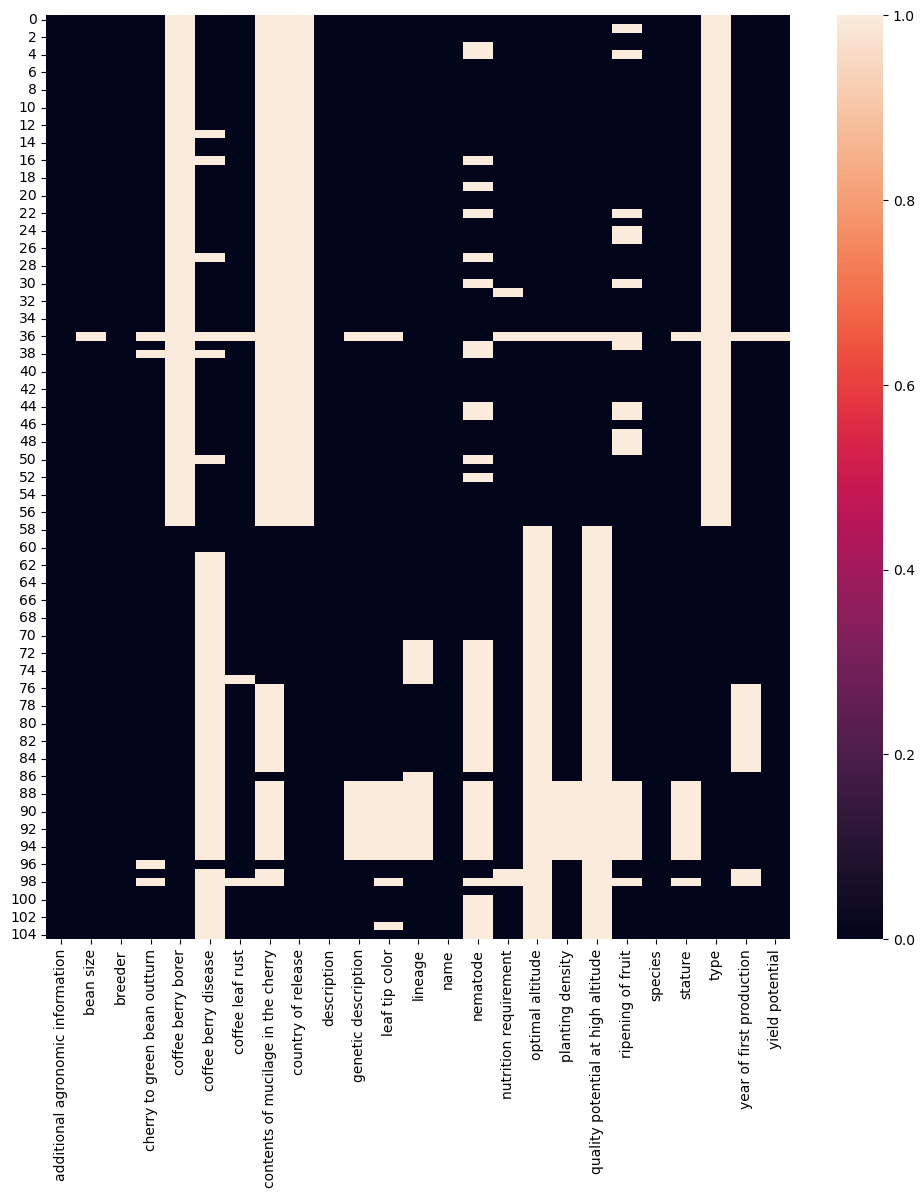

In [180]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.replace("Unknown", np.nan).replace("Not applicable", np.nan).isnull())
plt.show()

In [181]:
df = df.drop(columns=['coffee berry borer', 'type', 'contents of mucilage in the cherry'])

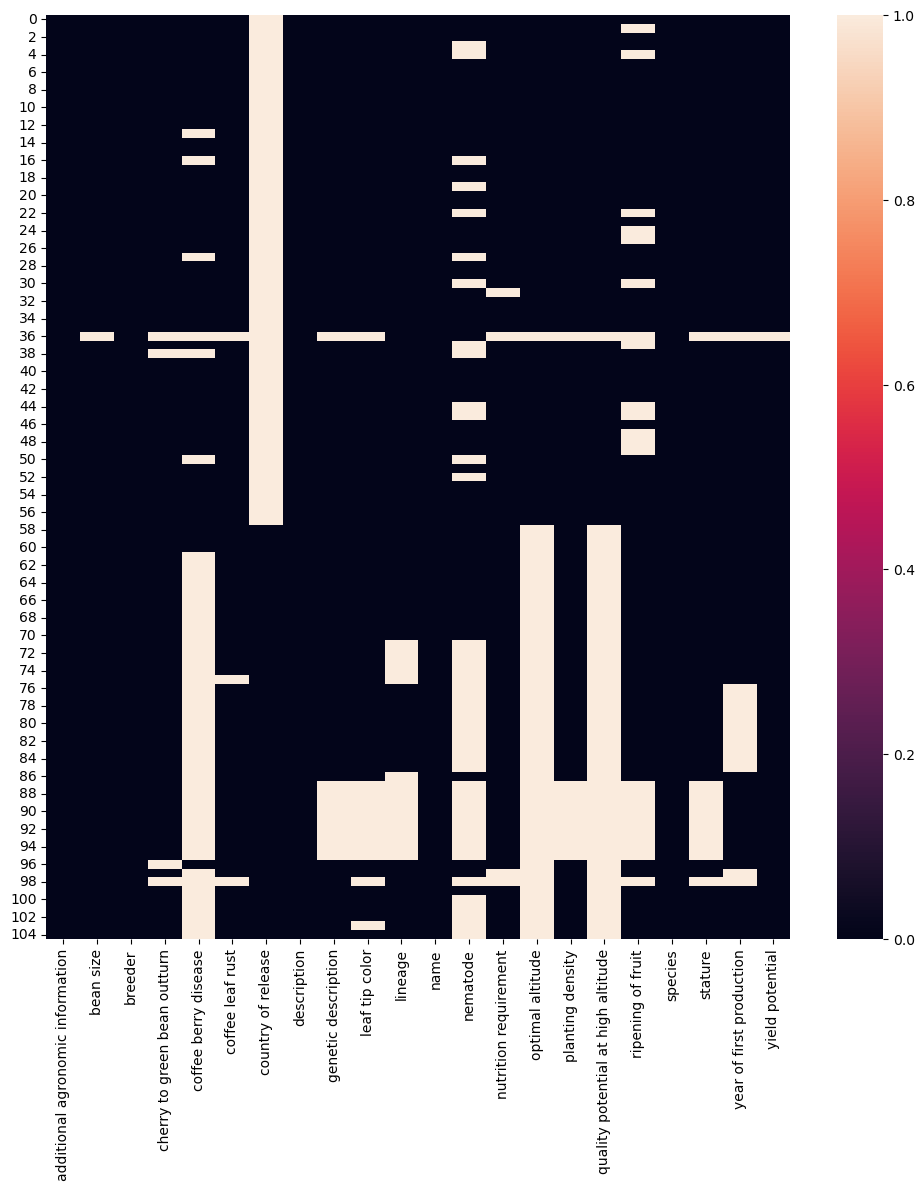

In [182]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.replace("Unknown", np.nan).replace("Not applicable", np.nan).isnull())
plt.show()

In [184]:
df.to_csv('./intermediates/processed_coffee_data_v3.csv', index=False)

## Almost There

In [194]:
df = pd.read_csv('./intermediates/processed_coffee_data_v4.csv')
df

,additional agronomic information,bean size,breeder,cherry to green bean outturn,coffee berry disease,coffee leaf rust,country of release,description,genetic description,leaf tip color,...,nematode,nutrition requirement,optimal altitude,planting density,quality potential at high altitude,ripening of fruit,species,stature,year of first production,yield potential
0,Anacafe 14 is drought tolerant. Anacafe 14 is ...,Very Large,National Coffee Association of Guatemala (ANAC...,High,Susceptible,Resistant,Guatemala,"Very high yielding variety, with rust resistan...",Introgressed (Catimor related),Green,...,Susceptible,High,"Medium , High",4000-5000 plants/ha (using single-stem pruning),Good,Late,Arabica,Compact,Year 2,High
1,Well-adapted for smallholders because of its r...,Very Large,Coffee Research Foundation (now Kenya Agricult...,High,Resistant,Tolerant,Kenya,"A tall variety that combines high yields, tole...",Introgressed (Other),Green or Bronze,...,Susceptible,Medium,Low,2000-3000 plants/ha (using multiple-stem pruning),Very Good,Unknown,Arabica,Tall,Year 2,High
2,Unknown,Average,Unknown,Average,Susceptible,Susceptible,Brazil,One of the most culturally and genetically imp...,Bourbon-Typica group (Bourbon related),Green,...,Susceptible,Medium,High,3000-4000 plants/ha (using single-stem pruning),Very Good,Early,Arabica,Tall,Year 4,Medium
3,Unknown,Large,Rwanda Agricultural Board (RAB),Average,Susceptible,Susceptible,Rwanda,Vigorous and highly productive tall variety wi...,Bourbon-Typica group (Bourbon related),Bronze,...,Unknown,Medium,High,2000-3000 plants/ha (using multiple-stem pruning),Very Good,Average,Arabica,Tall,Year 3,High
4,Unknown,Large,Rwanda Agricultural Board (RAB),Average,Susceptible,Susceptible,Rwanda,"Moderate yield, good cup potential, and suscep...",Bourbon-Typica group (Bourbon related),Bronze,...,Unknown,Medium,"Medium , High",1000-2000 plants/ha (using single-stem pruning),Good,Unknown,Arabica,Tall,Year 3,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Resistant to coffee leaf rust and high cup qua...,Medium,Western Highlands Agroforestry Science Institu...,High,Unknown,Tolerant,Vietnam,Very high yield and quality. Strong growth.,Congo group,Green,...,Unknown,High,Unknown,1000-2000 plants/ha (using single-stem pruning),Unknown,Late,Robusta,Tall,Year 2,High
100,High and stable yield and quality. Strong seco...,Medium,Western Highlands Agroforestry Science Institu...,High,Unknown,Tolerant,Vietnam,High yield and wide adaptation to different en...,Congo group,Green,...,Unknown,High,Unknown,1000-2000 plants/ha (using single-stem pruning),Unknown,Average,Robusta,Compact,Year 2,Very High
101,Resistant to coffee leaf rust and high cup qua...,Large,Western Highlands Agroforestry Science Institu...,High,Unknown,Tolerant,Vietnam,"Very high yield and cup quality, large bean size.",Congo group,Dark Bronze,...,Unknown,High,Unknown,1000-2000 plants/ha (using single-stem pruning),Unknown,Late,Robusta,Compact,Year 2,High
102,Because this plant is a polyclonal/synthetic v...,Medium,Western Highlands Agroforestry Science Institu...,High,Unknown,Tolerant,Vietnam,Wide adaptation to different environments; ave...,Congo group,Unknown,...,Unknown,Medium,Unknown,1000-2000 plants/ha (using single-stem pruning),Unknown,Average,Robusta,Compact,Year 3,Good


In [195]:
df = df.replace("Unknown", np.nan)
df = df.applymap(lambda x: x.replace(" ,", ",") if isinstance(x, str) else x)
df

,additional agronomic information,bean size,breeder,cherry to green bean outturn,coffee berry disease,coffee leaf rust,country of release,description,genetic description,leaf tip color,...,nematode,nutrition requirement,optimal altitude,planting density,quality potential at high altitude,ripening of fruit,species,stature,year of first production,yield potential
0,Anacafe 14 is drought tolerant. Anacafe 14 is ...,Very Large,National Coffee Association of Guatemala (ANAC...,High,Susceptible,Resistant,Guatemala,"Very high yielding variety, with rust resistan...",Introgressed (Catimor related),Green,...,Susceptible,High,"Medium, High",4000-5000 plants/ha (using single-stem pruning),Good,Late,Arabica,Compact,Year 2,High
1,Well-adapted for smallholders because of its r...,Very Large,Coffee Research Foundation (now Kenya Agricult...,High,Resistant,Tolerant,Kenya,"A tall variety that combines high yields, tole...",Introgressed (Other),Green or Bronze,...,Susceptible,Medium,Low,2000-3000 plants/ha (using multiple-stem pruning),Very Good,NaN,Arabica,Tall,Year 2,High
2,NaN,Average,NaN,Average,Susceptible,Susceptible,Brazil,One of the most culturally and genetically imp...,Bourbon-Typica group (Bourbon related),Green,...,Susceptible,Medium,High,3000-4000 plants/ha (using single-stem pruning),Very Good,Early,Arabica,Tall,Year 4,Medium
3,NaN,Large,Rwanda Agricultural Board (RAB),Average,Susceptible,Susceptible,Rwanda,Vigorous and highly productive tall variety wi...,Bourbon-Typica group (Bourbon related),Bronze,...,NaN,Medium,High,2000-3000 plants/ha (using multiple-stem pruning),Very Good,Average,Arabica,Tall,Year 3,High
4,NaN,Large,Rwanda Agricultural Board (RAB),Average,Susceptible,Susceptible,Rwanda,"Moderate yield, good cup potential, and suscep...",Bourbon-Typica group (Bourbon related),Bronze,...,NaN,Medium,"Medium, High",1000-2000 plants/ha (using single-stem pruning),Good,NaN,Arabica,Tall,Year 3,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Resistant to coffee leaf rust and high cup qua...,Medium,Western Highlands Agroforestry Science Institu...,High,NaN,Tolerant,Vietnam,Very high yield and quality. Strong growth.,Congo group,Green,...,NaN,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Late,Robusta,Tall,Year 2,High
100,High and stable yield and quality. Strong seco...,Medium,Western Highlands Agroforestry Science Institu...,High,NaN,Tolerant,Vietnam,High yield and wide adaptation to different en...,Congo group,Green,...,NaN,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Average,Robusta,Compact,Year 2,Very High
101,Resistant to coffee leaf rust and high cup qua...,Large,Western Highlands Agroforestry Science Institu...,High,NaN,Tolerant,Vietnam,"Very high yield and cup quality, large bean size.",Congo group,Dark Bronze,...,NaN,High,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Late,Robusta,Compact,Year 2,High
102,Because this plant is a polyclonal/synthetic v...,Medium,Western Highlands Agroforestry Science Institu...,High,NaN,Tolerant,Vietnam,Wide adaptation to different environments; ave...,Congo group,NaN,...,NaN,Medium,NaN,1000-2000 plants/ha (using single-stem pruning),NaN,Average,Robusta,Compact,Year 3,Good


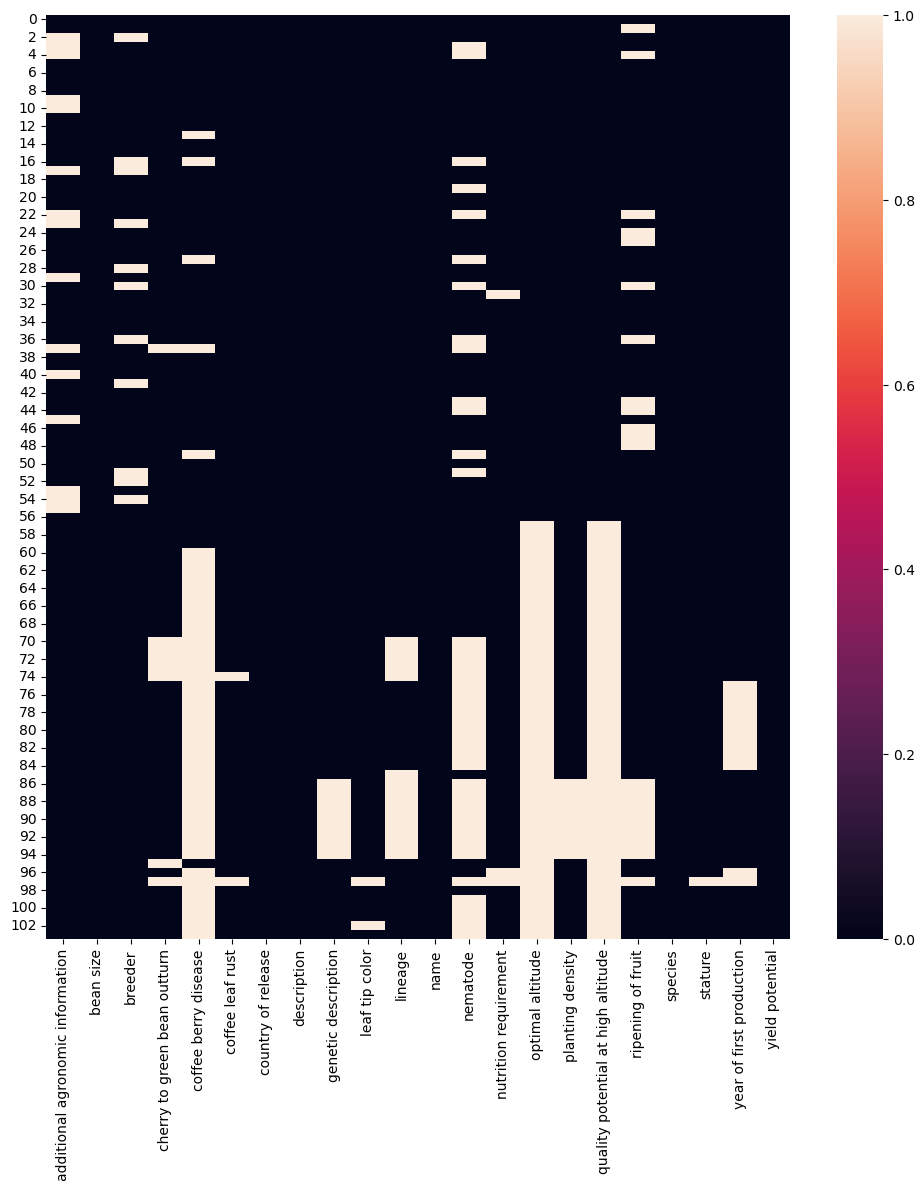

In [196]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.isnull())
plt.show()

In [197]:
df.to_csv('processed_coffee_data_v5.csv', index=False)

## Reasonably Clean Dataset (JSON)

In [198]:
json_path = "processed_coffee_data_v5.json"
df.to_json(json_path, orient="records", indent=4)